In [1]:
from langgraph.graph import END , StateGraph, MessagesState, START
from langchain_core.messages import convert_to_messages, RemoveMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.config import RunnableConfig
from chains.chains import intent_recognition_chain, rephrase_chain, categorize_chain
from vector_store.chroma_management import add_new_doc
import os
from dotenv import load_dotenv
load_dotenv()
import re

def clean_newlines(input_string):
    # Remove all newline characters from the string
    cleaned_string = re.sub(r'\n', '', input_string)
    return cleaned_string


llmG = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b", google_api_key=os.getenv("GOOGLE_API_KEY"))

class AgentState(MessagesState):
    """The state of the graph"""
    user_id:str
    message_id:str
    message_text :str
    summary_text : str
    current : str


def intent_recognition_node(state : AgentState):
    """"""
    print(f"The state in Intent {state}")
    intent_recognition_runnable = intent_recognition_chain(llm=llmG)
    result = intent_recognition_runnable.invoke({"user_input": state["messages"][-1].content})

    return {"messages": [result], "current": "Intent"}


def check_message_node(state: AgentState):
    """Check if the user's message message exist"""
    print(f"The state in Check {state}")
    result = add_new_doc(state["user_id"], state["message_id"], state["message_text"])
    print(result)
    return {"messages":[result], "current":"Check Message"}

def rephrase_node(state : AgentState):
    print(f"The state in rephrase {state}")

    rephrase_runnable = rephrase_chain(llm=llmG)
    result = rephrase_runnable.invoke({"user_input": state["message_text"]})
    return {"messages":[result], "current":"Rephrase"}

def categorize_node(state : AgentState):
    print(f"The state in rephrase {state}")

    categorize_runnable = categorize_chain(llm=llmG)
    result = categorize_runnable.invoke({"user_input": state["message_text"], "summary":state["messages"][-1].content})
    return {"messages":[result], "current":"Categorize", "summary_text":state["messages"][-1].content}

def if_complaint(state:AgentState):
    result = state["messages"][-1].content
    clean=clean_newlines(result)
    print(f"clean {clean}")
    if clean == "True":
        return "check"
    else:
        return END
    
def if_msg_exist(state:AgentState):
    result = state["messages"][-1].content
    clean=clean_newlines(result)
    print(f"clean {clean}")
    if clean == "added":
        return "rephrase"
    else:
        return END

workflow = StateGraph(AgentState)

workflow.add_node("intent", intent_recognition_node)
workflow.add_node("check", check_message_node)
workflow.add_node("rephrase", rephrase_node)
workflow.add_node("categorize", categorize_node)

workflow.add_edge(START, "intent")
workflow.add_conditional_edges("intent",if_complaint, {
    "check":"check",
    END:END
})
workflow.add_conditional_edges("check", if_msg_exist, {
    "rephrase":"rephrase",
    END : END
})

workflow.add_edge("rephrase", "categorize")


graph = workflow.compile()



c:\Users\ranim\OneDrive\Documents\projects\hackathon\Hackthon\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


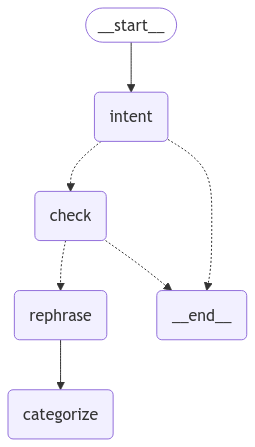

In [2]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [2]:
def graph_stream(user_input):
        # Process the query using graph.astream
    user_input_message = HumanMessage(content=user_input)


    for event in graph.stream(
            {"messages": [user_input_message], "user_id":"testid","message_id":"12","message_text":user_input, "summary_text":""},
            stream_mode="values",
        ):
        print(f"Processed event: {event}")
            
    return event


graph_stream("im not happy with the packaging")

Processed event: {'messages': [HumanMessage(content='im not happy with the packaging', additional_kwargs={}, response_metadata={}, id='1f9695df-66dd-4e8f-83c5-9b767e0a39b9')], 'user_id': 'testid', 'message_id': '12', 'message_text': 'im not happy with the packaging', 'summary_text': ''}
The state in Intent {'messages': [HumanMessage(content='im not happy with the packaging', additional_kwargs={}, response_metadata={}, id='1f9695df-66dd-4e8f-83c5-9b767e0a39b9')], 'user_id': 'testid', 'message_id': '12', 'message_text': 'im not happy with the packaging', 'summary_text': ''}
clean True
Processed event: {'messages': [HumanMessage(content='im not happy with the packaging', additional_kwargs={}, response_metadata={}, id='1f9695df-66dd-4e8f-83c5-9b767e0a39b9'), AIMessage(content='True\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NE

{'messages': [HumanMessage(content='im not happy with the packaging', additional_kwargs={}, response_metadata={}, id='1f9695df-66dd-4e8f-83c5-9b767e0a39b9'),
  AIMessage(content='True\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-aaf29a2e-b68d-4020-aa90-a98d19e64975-0', usage_metadata={'input_tokens': 210, 'output_tokens': 2, 'total_tokens': 212, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='exists', additional_kwargs={}, response_metadata={}, id='d788db28-afcb-46cf-a882-1f87e9780659')],